<a href="https://colab.research.google.com/github/ChristianParsons98/PG_Lab_Code/blob/main/LLTO_A_Raman_FullFit_V4_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install lmfit

In [56]:
%matplotlib inline
from sympy import init_printing
init_printing(use_latex=True)
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import pandas as pd
import math
import scipy
from scipy.stats import chisquare
print(scipy.__version__)
from scipy.optimize import leastsq
from scipy.special import voigt_profile
from sklearn.metrics import r2_score
import csv
from scipy.signal import find_peaks
import lmfit
from lmfit.models import VoigtModel, LinearModel, GaussianModel, LorentzianModel


#This document is used to fit the raman data to Lorentzians
#For LLTO made with Anatase

#Uses file /content/LLTO-2.PRN


1.16.1


In [57]:
#Importing the Results for LLTO and LLYTO

def Load_Raman_Data(file_path):
    #Function to load tab-delimited .PRN Raman data from Renishaw
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['wavenumber', 'intensity'])
    return df


#Load the file file
dfA2 = Load_Raman_Data('/content/LLTO-2.PRN')

wna2 = dfA2['wavenumber'].to_numpy()
wna2 = wna2[:-1].astype(float)
intensitya2 = dfA2['intensity'].to_numpy()[:-1]

In [58]:
#Helper function to find peak indicies.
peaks, _ = find_peaks(intensitya2, prominence=1000)
#peaks = find_peaks(intensitya2, prominence=1000)
for peak in peaks:
  print(wna2[peak])

142.98
237.25
315.81
456.16
526.34
784.0


In [59]:
#If the peak is not showing up above this may help.

#helper function to find index closest to my guess angle
def closest(lst, K):
    val=lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return lst.index(val)

#helper function to find index of nearest peak given a guess index
def peakfind(lst,K):
    temp=lst[K-15:K+15]
    maxval=max(temp)
    mindx=temp.index(maxval)
    #index = lst.index(maxval)
    index=K-15+mindx
    return index

In [60]:
#Example of using the above helper functions to find the index for a specific wavenumber
templst=wna2.tolist()
print(closest(templst,100))

48


In [61]:
#This function fits a voigt function for a given index
#x is the list form of wavenumber (nparray), y is the list form of Int (nparray)
#Takes the index of the peak center, and number of points to the left and right of the center
# that should be considered in the fit.
def VPeakFit(WN,Int,icenter,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki= icenter
    pkang= WN[pki]
    tempx=WN[pki-nleft:pki+nright]
    tempy=Int[pki-nleft:pki+nright]

    #Fitting
    #Define the model for a single peak
    model = VoigtModel(prefix='p0_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang, min=pkang-20, max=pkang+20)
    params.add(f'p0_sigma', value=20, min=0.01)
    params.add(f'p0_gamma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)

    result = model.fit(tempy, params, x=tempx)
    result.plot()
    print(result.fit_report())

In [62]:
#This function fits a Lorentzian function for a given index
#x is the list form of wavenumber (nparray), y is the list form of Int (nparray)
#Takes the index of the peak center, and number of points to the left and right of the center
# that should be considered in the fit.
def LPeakFit(WN,Int,icenter,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki= icenter
    pkang= WN[pki]
    tempx=WN[pki-nleft:pki+nright]
    tempy=Int[pki-nleft:pki+nright]

    #Fitting
    #Define the model for a single peak
    model = LorentzianModel(prefix='p0_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang, min=pkang-20, max=pkang+20)
    params.add(f'p0_sigma', value=20, min=0.01)
    #params.add(f'p0_gamma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)

    result = model.fit(tempy, params, x=tempx)
    #result.plot()
    #print(result.fit_report())
    return result

In [63]:
#Same as above but for jointly fitting the two peaks that should be around 500
# One at ~525 and the other at ~580
# icenters is a list of two peak center indicies - lower index first.
def L2PeakFit(WN,Int,icenters,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki1= icenters[0]
    pkang1= WN[pki1]
    pki2= icenters[1]
    pkang2= WN[pki2]
    tempx=WN[pki1-nleft:pki2+nright]
    tempy=Int[pki1-nleft:pki2+nright]

    #Fitting
    #Define the model for a single peak
    model = LorentzianModel(prefix='p0_')
    model += LorentzianModel(prefix='p1_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang1, min=pkang1-10, max=pkang1+10)
    params.add(f'p0_sigma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)
    params.add(f'p1_center', value=pkang2, min=pkang2-20, max=pkang2+20)
    params.add(f'p1_sigma', value=20, min=0.01)
    params.add(f'p1_amplitude', value=1000000, min=0)


    result = model.fit(tempy, params, x=tempx)
    return result

In [64]:
#Now we go through and fit each peak individually...

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 20
    # variables        = 3
    chi-square         = 1.3638e+08
    reduced chi-square = 8022265.48
    Akaike info crit   = 320.704250
    Bayesian info crit = 323.691447
    R-squared          = 0.99685739
[[Variables]]
    p0_center:     142.686672 +/- 0.04140160 (0.03%) (init = 142.98)
    p0_sigma:      14.2790543 +/- 0.12030103 (0.84%) (init = 20)
    p0_amplitude:  19038875.7 +/- 129245.401 (0.68%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude) = +0.9675


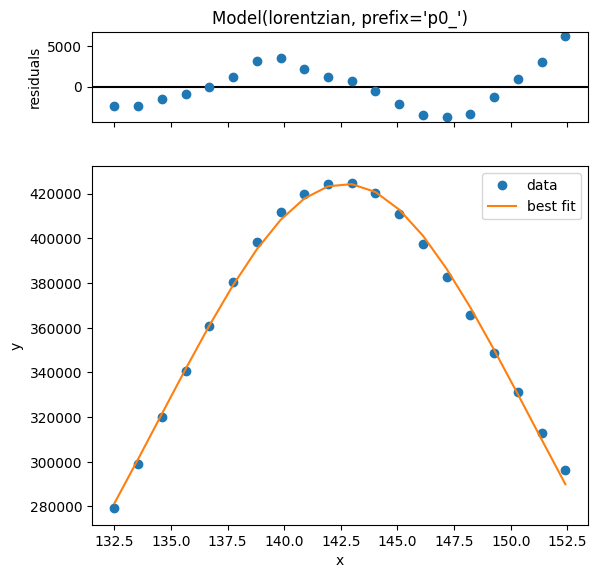

In [65]:
Peak1 = LPeakFit(wna2, intensitya2,peaks[0],10,10)
Peak1.plot()
print(Peak1.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 20
    # variables        = 3
    chi-square         = 681568.941
    reduced chi-square = 40092.2906
    Akaike info crit   = 214.728408
    Bayesian info crit = 217.715605
    R-squared          = 0.99729335
[[Variables]]
    p0_center:     237.168389 +/- 0.03569031 (0.02%) (init = 237.25)
    p0_sigma:      36.9580826 +/- 0.24575495 (0.66%) (init = 20)
    p0_amplitude:  18253050.0 +/- 115580.609 (0.63%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9989
    C(p0_center, p0_amplitude) = +0.1487
    C(p0_center, p0_sigma)     = +0.1459


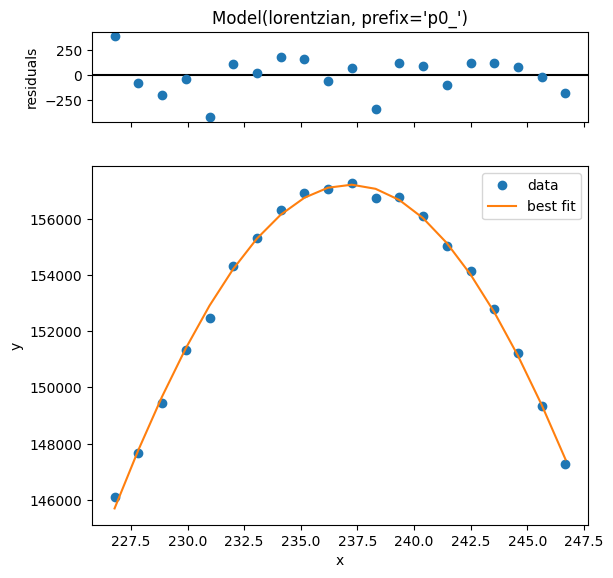

In [66]:
Peak2 = LPeakFit(wna2, intensitya2,peaks[1],10,10)
Peak2.plot()
print(Peak2.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 20
    # variables        = 3
    chi-square         = 4909134.28
    reduced chi-square = 288772.605
    Akaike info crit   = 254.217518
    Bayesian info crit = 257.204715
    R-squared          = 0.97668933
[[Variables]]
    p0_center:     314.504104 +/- 0.11151625 (0.04%) (init = 315.81)
    p0_sigma:      31.9687295 +/- 0.65346351 (2.04%) (init = 20)
    p0_amplitude:  10672615.4 +/- 204849.851 (1.92%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9981
    C(p0_center, p0_amplitude) = -0.2502
    C(p0_center, p0_sigma)     = -0.2441


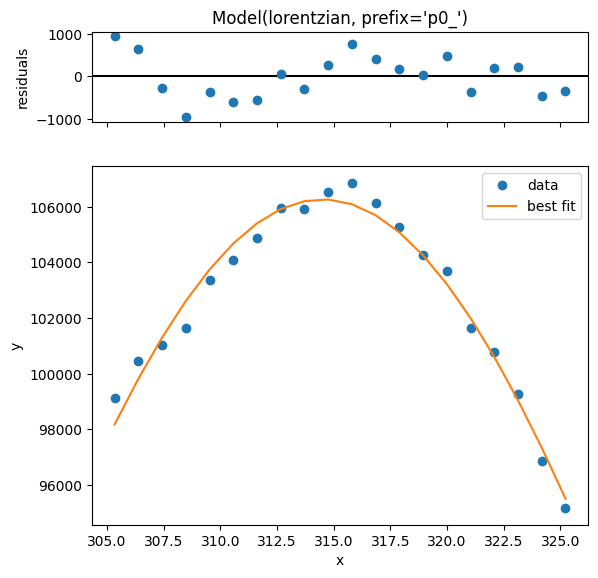

In [67]:
Peak3 = LPeakFit(wna2, intensitya2,peaks[2],10,10)
Peak3.plot()
print(Peak3.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 20
    # variables        = 3
    chi-square         = 888701.442
    reduced chi-square = 52276.5554
    Akaike info crit   = 220.035687
    Bayesian info crit = 223.022884
    R-squared          = 0.93552292
[[Variables]]
    p0_center:     458.240699 +/- 0.32416025 (0.07%) (init = 456.16)
    p0_sigma:      51.4493136 +/- 2.29103861 (4.45%) (init = 20)
    p0_amplitude:  8006318.89 +/- 348865.845 (4.36%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9997
    C(p0_center, p0_amplitude) = +0.6807
    C(p0_center, p0_sigma)     = +0.6737


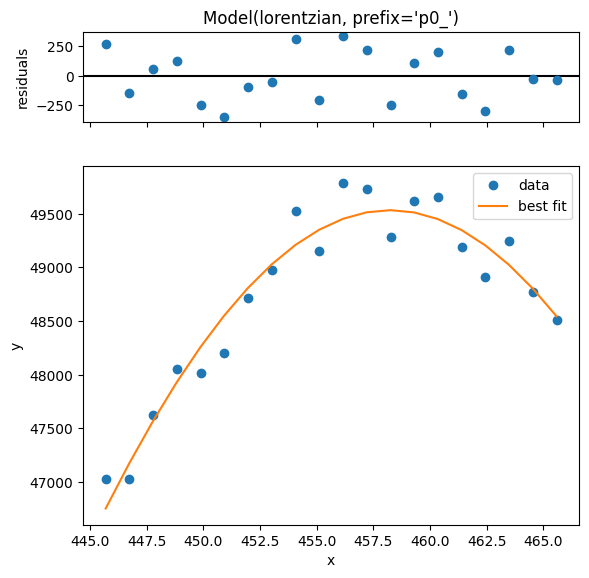

In [68]:
Peak4 = LPeakFit(wna2, intensitya2,peaks[3],10,10)
Peak4.plot()
print(Peak4.fit_report())

[[Model]]
    (Model(lorentzian, prefix='p0_') + Model(lorentzian, prefix='p1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 81
    # variables        = 6
    chi-square         = 6417690.98
    reduced chi-square = 85569.2130
    Akaike info crit   = 925.689703
    Bayesian info crit = 940.056398
    R-squared          = 0.99986313
[[Variables]]
    p0_center:     524.829366 +/- 0.05031106 (0.01%) (init = 526.34)
    p0_sigma:      26.8518742 +/- 0.24154575 (0.90%) (init = 20)
    p0_amplitude:  8059724.33 +/- 165122.388 (2.05%) (init = 1000000)
    p1_center:     574.744300 +/- 0.87396385 (0.15%) (init = 579.76)
    p1_sigma:      54.6332460 +/- 2.07643099 (3.80%) (init = 20)
    p1_amplitude:  5713444.79 +/- 302467.959 (5.29%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p1_sigma, p1_amplitude)     = +0.9903
    C(p0_amplitude, p1_amplitude) = -0.9791
    C(p0_sigma, p0_amplitude)     = +0

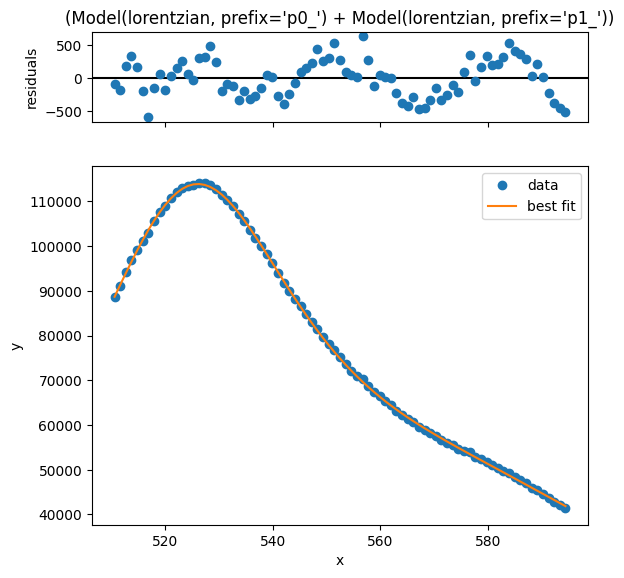

In [69]:
#The peaks at 525 and 580 near the indices 455 and 506.
Peaks5_6 = L2PeakFit(wna2, intensitya2,[455,506],15,15)
Peaks5_6.plot()
print(Peaks5_6.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 80
    # variables        = 3
    chi-square         = 4193373.87
    reduced chi-square = 54459.4009
    Akaike info crit   = 875.359164
    Bayesian info crit = 882.505244
    R-squared          = 0.95377419
[[Variables]]
    p0_center:     782.351535 +/- 0.28297241 (0.04%) (init = 784)
    p0_sigma:      126.914099 +/- 1.68630259 (1.33%) (init = 20)
    p0_amplitude:  13902603.6 +/- 173143.026 (1.25%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude) = +0.9981


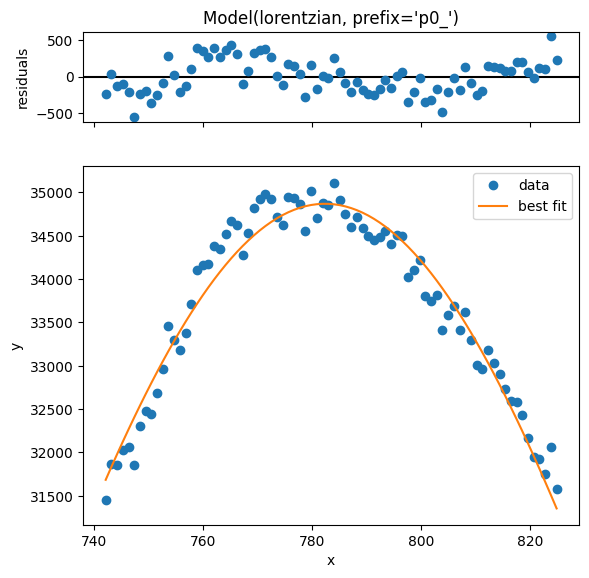

In [70]:
Peak7 = LPeakFit(wna2, intensitya2,peaks[5],40,40)
Peak7.plot()
print(Peak7.fit_report())

In [71]:
def lorentzian(x, x0, sigma, amplitude):
        return amplitude/np.pi * (sigma / ((x - x0)**2 + sigma**2))

In [72]:
#But the amplitude is not exactly correct when we jointly fit. Peak center should be ok.

In [73]:
#Let's make a list of values
pvlst=[]

#peaks 1-4
PL = [Peak1, Peak2, Peak3, Peak4]
for peak in PL:
    tdl = list(peak.params.valuesdict().values())
    pvlst.append(tdl)
#peaks 5-6
pvlst.append(list(Peaks5_6.params.valuesdict().values())[:3])
pvlst.append(list(Peaks5_6.params.valuesdict().values())[3:])
#peak 7
pvlst.append(list(Peak7.params.valuesdict().values()))

print(pvlst)

[[142.6866718861929, 14.279054337673143, 19038875.659615282], [237.16838920136195, 36.95808264060001, 18253050.017969664], [314.5041036109601, 31.968729489874075, 10672615.387802968], [458.2406991014487, 51.449313585282155, 8006318.891920026], [524.8293662755078, 26.851874238561344, 8059724.330455682], [574.7443000361253, 54.633246012861555, 5713444.793889935], [782.3515354485635, 126.91409929009359, 13902603.63717527]]


[[Model]]
    ((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 912
    # data points      = 833
    # variables        = 14
    chi-square         = 2.5599e+10
    reduced chi-square = 31256014.2
    Akaike info crit   = 14389.5638
    Bayesian info crit = 14455.7142
    R-squared          = 0.99282833
##  Warning: uncertainties could not be estimated:
    p2_sigma:      at boundary
    p3_sigma:      at boundary
    p4_sigma:      at boundary
    p5_sigma:      at boundary
    p6_sigma:      at boundary
[[Variables]]
    p1_center:     142.6867 (fixed)
    p1_sigma:      15.6895205 (init = 14.27905)
    p1_amplitude:  18917525.3 (init = 1.903888e+07)
    p2_center:     237.1684 (fixed)
    p2_sigma:      44.349696

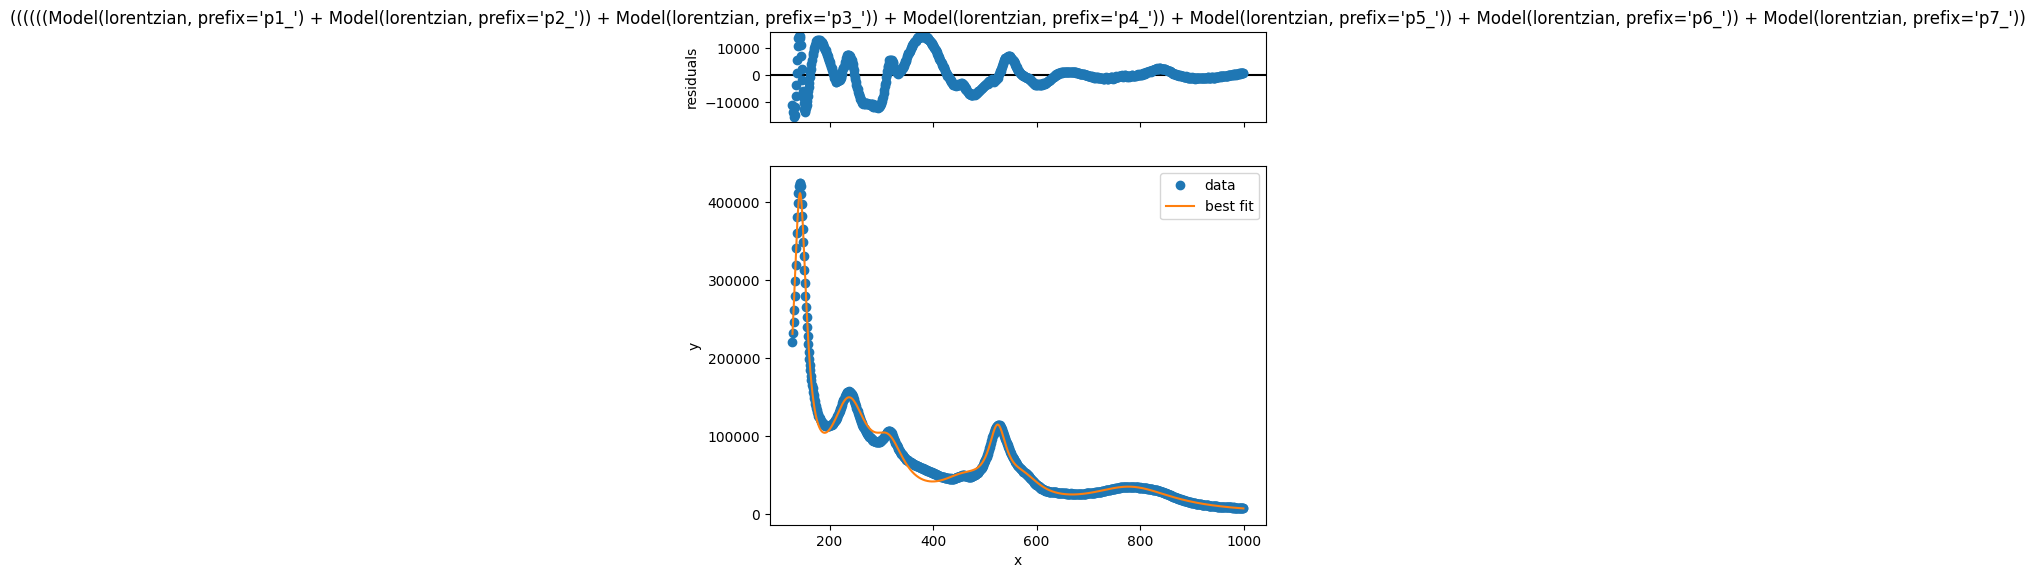

In [74]:
#We will see that we cannot fully fit the spectrum with the expected 7 peaks.
#There is a small piece missing around 390 cm-1...
#This first one is the required
model = LorentzianModel(prefix='p1_')
for i in range(2, 8):
    model += LorentzianModel(prefix=f'p{i}_')
#Instantiate the Parameters() object for lmfit
params = lmfit.Parameters()
for i in range(1,8):
    params.add(f'p{i}_center', value=pvlst[i-1][0], vary=False)
    params.add(f'p{i}_sigma', value=pvlst[i-1][1], min=pvlst[i-1][1]*0.8, max=pvlst[i-1][1]*1.2)
    params.add(f'p{i}_amplitude', value=pvlst[i-1][2], min=pvlst[i-1][2]*0.5, max=pvlst[i-1][2]*1.5)

result = model.fit(intensitya2[75:], params, x=wna2[75:])
result.plot()
print(result.fit_report())

[[Model]]
    (((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_')) + Model(lorentzian, prefix='p8_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 459
    # data points      = 833
    # variables        = 17
    chi-square         = 1.1569e+10
    reduced chi-square = 14178243.4
    Akaike info crit   = 13734.0177
    Bayesian info crit = 13814.3433
    R-squared          = 0.99675873
[[Variables]]
    p1_center:     142.6867 (fixed)
    p1_sigma:      15.6737631 +/- 0.09489177 (0.61%) (init = 14.27905)
    p1_amplitude:  18931435.0 +/- 97754.0479 (0.52%) (init = 1.903888e+07)
    p2_center:     237.1684 (fixed)
    p2_sigma:      43.8647554 +/- 0.53991189 (1.23%) (init = 36.95808)
    p2_amplitude:  17693612.1 +/- 198601.924 (1.12%) (init = 1.825305e+07)
    p3

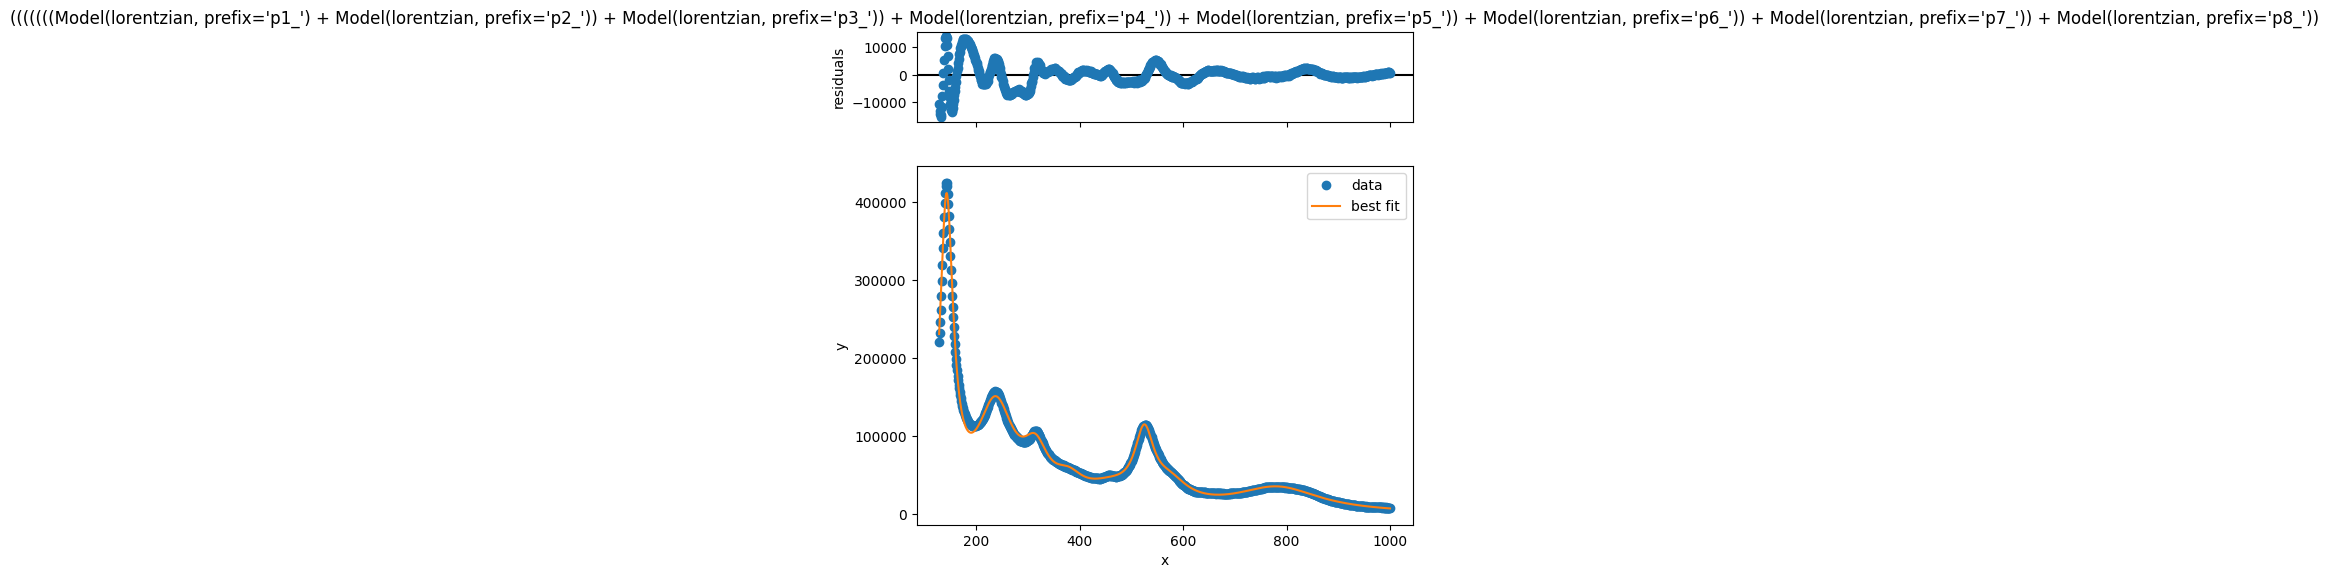

In [75]:
#As above but adding an additional peak around 390
#This first one is the required
model = LorentzianModel(prefix='p1_')
for i in range(2, 9):
    model += LorentzianModel(prefix=f'p{i}_')
#Instantiate the Parameters() object for lmfit
params = lmfit.Parameters()
for i in range(1,8):
    params.add(f'p{i}_center', value=pvlst[i-1][0], vary=False)
    params.add(f'p{i}_sigma', value=pvlst[i-1][1], min=pvlst[i-1][1]*0.8, max=pvlst[i-1][1]*1.2)
    params.add(f'p{i}_amplitude', value=pvlst[i-1][2], min=pvlst[i-1][2]*0.5, max=pvlst[i-1][2]*1.5)

#There seems to be something going on around ~390 that needs to be accounted for...
params.add(f'p8_center', value=390, min=360, max=420)
params.add(f'p8_sigma', value=20, min=0.01)
params.add(f'p8_amplitude', value=1000000, min=0)


result = model.fit(intensitya2[75:], params, x=wna2[75:])
result.plot()
print(result.fit_report())

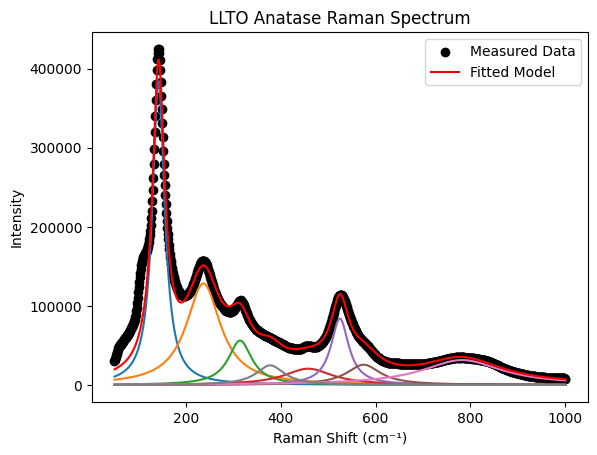

In [76]:
#Make a nice plot

ysim=np.zeros(1000)
xsim=np.linspace(50,1000,1000)

rdict = result.params.valuesdict()

plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity")
plt.title("LLTO Anatase Raman Spectrum")
plt.scatter(wna2,intensitya2, c='k', label='Measured Data')
for i in range(1,9):
  y= lorentzian(xsim, rdict[f'p{i}_center'], rdict[f'p{i}_sigma'], rdict[f'p{i}_amplitude'])
  ysim+=y
  plt.plot(xsim,y)
plt.plot(xsim,ysim,'r', label='Fitted Model')
plt.legend()
plt.savefig('LLTO_Anatase_Raman_FullFit.png',dpi=600)
plt.show()

In [77]:
print('LLTO_Anatase_Params')
result.params.valuesdict()

LLTO_Anatase_Params


{'p1_center': 142.6866718861929,
 'p1_sigma': 15.673763061106012,
 'p1_amplitude': 18931435.037918147,
 'p2_center': 237.16838920136195,
 'p2_sigma': 43.86475537416057,
 'p2_amplitude': 17693612.13641512,
 'p3_center': 314.5041036109601,
 'p3_sigma': 30.241464190891648,
 'p3_amplitude': 5336307.694066071,
 'p4_center': 458.2406991014487,
 'p4_sigma': 61.73917630202071,
 'p4_amplitude': 4003159.446077563,
 'p5_center': 524.8293662755078,
 'p5_sigma': 22.780049978529107,
 'p5_amplitude': 6004483.134826701,
 'p6_center': 574.7443000361253,
 'p6_sigma': 43.70659681085562,
 'p6_amplitude': 3522338.2762588216,
 'p7_center': 782.3515354485635,
 'p7_sigma': 102.384740932939,
 'p7_amplitude': 10142651.327422746,
 'p8_center': 378.0199987441588,
 'p8_sigma': 36.07142414952786,
 'p8_amplitude': 2815216.5618286896}